<a href="https://colab.research.google.com/github/z1mmz/ML-Notebooks/blob/master/Melbourne%20carpark%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
import numpy as np
import dateutil.parser as dparser

In [90]:
# from google.colab import drive
# drive.mount('/content/drive/MyDrive/carpark prediction/')

In [91]:
weather = pd.read_csv("/content/drive/MyDrive/carpark prediction/meshed-sensor-type-1.csv")
parking = pd.read_csv("/content/drive/MyDrive/carpark prediction/on-street-parking-bay-sensors.csv")

In [92]:

parking[['lat','lon']] =parking["Location"].str.split(',',expand=True)
parking["Hour"] = parking["Status_Timestamp"].apply(lambda x : dparser.parse(x,fuzzy=True).time().hour)
parking["Weekday"] = parking["Status_Timestamp"].apply(lambda x : dparser.parse(x,fuzzy=True).date().weekday())
parking["date"] = parking["Status_Timestamp"].apply(lambda x : dparser.parse(x,fuzzy=True).date())

In [93]:
weather["date"] = weather["time"].apply(lambda x : dparser.parse(x,fuzzy=True).date())

In [94]:
dataset = pd.merge(parking,weather,how="left",on="date")

In [95]:
dataset.head(10)

,Lastupdated,Status_Timestamp,Zone_Number,Status_Description,Parkingbay_ID,Location,lat,lon,Hour,Weekday,...,solar,precipitation,strikes,windspeed,winddirection,gustspeed,vapourpressure,atmosphericpressure,relativehumidity,airtemp
0,2023-07-20T15:44:36+10:00,2023-07-20T07:24:38+10:00,7358.0,Unoccupied,7075,"-37.814590620776784, 144.96934964923082",-37.814590620776784,144.96934964923082,7,3,...,0.0,0.0,0.0,0.68,161.1,1.65,1.03,100.80,82.0,10.3
1,2023-07-20T15:44:36+10:00,2023-07-20T07:24:38+10:00,7358.0,Unoccupied,7075,"-37.814590620776784, 144.96934964923082",-37.814590620776784,144.96934964923082,7,3,...,0.0,0.0,0.0,1.00,35.7,5.05,1.03,100.82,82.0,10.4
2,2023-07-20T15:44:36+10:00,2023-07-20T07:24:38+10:00,7358.0,Unoccupied,7075,"-37.814590620776784, 144.96934964923082",-37.814590620776784,144.96934964923082,7,3,...,0.0,0.0,0.0,0.70,28.0,2.46,1.04,100.91,83.0,10.3
3,2023-07-20T15:44:36+10:00,2023-07-20T07:24:38+10:00,7358.0,Unoccupied,7075,"-37.814590620776784, 144.96934964923082",-37.814590620776784,144.96934964923082,7,3,...,0.0,0.0,0.0,0.50,79.2,1.44,1.03,100.94,83.0,10.1
4,2023-07-20T15:44:36+10:00,2023-07-20T07:24:38+10:00,7358.0,Unoccupied,7075,"-37.814590620776784, 144.96934964923082",-37.814590620776784,144.96934964923082,7,3,...,0.0,0.0,0.0,0.61,58.9,1.85,1.01,100.95,83.0,9.9
5,2023-07-20T15:44:36+10:00,2023-07-20T07:24:38+10:00,7358.0,Unoccupied,7075,"-37.814590620776784, 144.96934964923082",-37.814590620776784,144.96934964923082,7,3,...,0.0,0.0,0.0,0.55,246.2,2.16,1.01,100.97,84.0,9.7
6,2023-07-20T15:44:36+10:00,2023-07-20T07:24:38+10:00,7358.0,Unoccupied,7075,"-37.814590620776784, 144.96934964923082",-37.814590620776784,144.96934964923082,7,3,...,23.0,0.0,0.0,0.82,131.5,4.31,0.99,100.56,80.0,10.1
7,2023-07-20T15:44:36+10:00,2023-07-20T07:24:38+10:00,7358.0,Unoccupied,7075,"-37.814590620776784, 144.96934964923082",-37.814590620776784,144.96934964923082,7,3,...,11.0,0.0,0.0,1.00,92.4,5.89,0.99,100.63,78.0,10.5
8,2023-07-20T15:44:36+10:00,2023-07-20T07:24:38+10:00,7358.0,Unoccupied,7075,"-37.814590620776784, 144.96934964923082",-37.814590620776784,144.96934964923082,7,3,...,6.0,0.0,0.0,1.27,41.5,4.47,1.00,100.60,78.0,10.6
9,2023-07-20T15:44:36+10:00,2023-07-20T07:24:38+10:00,7358.0,Unoccupied,7075,"-37.814590620776784, 144.96934964923082",-37.814590620776784,144.96934964923082,7,3,...,0.0,0.0,0.0,0.84,162.6,2.85,1.01,100.69,80.0,10.4


In [96]:
dataset["y"] = dataset["Status_Description"].apply(lambda x : 0 if x  == "Present" else 1 )

In [97]:
dataset = dataset.dropna(subset=["airtemp"])

In [98]:
weather.drop(["time","rtc","date","battery"],axis=1).columns.to_list()

['solarpanel',
 'command',
 'solar',
 'precipitation',
 'strikes',
 'windspeed',
 'winddirection',
 'gustspeed',
 'vapourpressure',
 'atmosphericpressure',
 'relativehumidity',
 'airtemp']

In [99]:
# + weather.drop(["time","rtc","date","battery"],axis=1).columns.to_list()
features = ["lat","lon","Hour","Weekday"] + weather.drop(["time","rtc","date","battery"],axis=1).columns.to_list()

In [100]:
features

['lat',
 'lon',
 'Hour',
 'Weekday',
 'solarpanel',
 'command',
 'solar',
 'precipitation',
 'strikes',
 'windspeed',
 'winddirection',
 'gustspeed',
 'vapourpressure',
 'atmosphericpressure',
 'relativehumidity',
 'airtemp']

In [101]:
X = dataset[features]
y = dataset["y"]

In [102]:
X.lat = pd.to_numeric(X.lat)

<ipython-input-102-5551987caed6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.lat = pd.to_numeric(X.lat)


In [103]:
X.lon = pd.to_numeric(X.lon)

<ipython-input-103-b56424cb3962>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.lon = pd.to_numeric(X.lon)


In [104]:
len(features)

16

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)

In [106]:
# from sklearn import preprocessing
# scaler = preprocessing.MinMaxScaler()
# x_train = scaler.fit_transform(X_train.values)
# x_test =  scaler.fit_transform(X_test.values)
x_train = X_train
x_test = X_test

In [107]:
import torch
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
# print(device)
device = "cpu"
X_train = torch.tensor(x_train.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(x_test.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1).to(device)

In [108]:
from torch.utils.data import DataLoader ,TensorDataset

loaded_train = DataLoader(TensorDataset(X_train,y_train), batch_size=25, shuffle=True)
loaded_test = DataLoader(TensorDataset(X_test,y_test), batch_size=25, shuffle=True)

In [109]:
X_train.shape

torch.Size([121457, 16])

In [110]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 255),
            nn.ReLU(),
            nn.Linear(255, 255),
            nn.ReLU(),
            nn.Linear(255, 255),
            nn.ReLU(),
            nn.Linear(255, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [111]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=255, bias=True)
    (1): ReLU()
    (2): Linear(in_features=255, out_features=255, bias=True)
    (3): ReLU()
    (4): Linear(in_features=255, out_features=255, bias=True)
    (5): ReLU()
    (6): Linear(in_features=255, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [112]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [113]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    correct_results_sum = (y_pred_tag == y_test).sum().float()

    # print(y_pred_tag == y_test)
    # print((y_pred_tag == y_test).sum().float())
    acc = correct_results_sum/y_test.shape[0]

    acc = torch.round(acc * 100)

    return acc

In [121]:
def train(dataloader, model, loss_fn, optimizer,losslist):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #compute loss
        pred = model(X)
        loss = loss_fn(pred, y)


        #backpropagtion
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losslist.append(loss.item())
        if batch % 1000 == 0:

            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [115]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct +=  binary_acc(pred,y)
    test_loss /= num_batches
    correct /= num_batches
    print(f"Test Error: \n Accuracy: {(correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [116]:
epochs = 3
losslist = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(loaded_train, model, loss_function, optimizer,losslist)
    test(loaded_test, model, loss_function)
print("Done!")

Epoch 1
-------------------------------
loss: 0.781226  [    0/121457]
loss: 0.667766  [25000/121457]
loss: 0.702356  [50000/121457]
loss: 0.708367  [75000/121457]
loss: 0.688468  [100000/121457]
Test Error: 
 Accuracy: 57.1%, Avg loss: 0.682529 

Epoch 2
-------------------------------
loss: 0.687438  [    0/121457]
loss: 0.713046  [25000/121457]
loss: 0.714631  [50000/121457]
loss: 0.691974  [75000/121457]
loss: 0.634777  [100000/121457]
Test Error: 
 Accuracy: 63.9%, Avg loss: 0.647020 

Epoch 3
-------------------------------
loss: 0.742087  [    0/121457]
loss: 0.678351  [25000/121457]
loss: 0.661221  [50000/121457]
loss: 0.627817  [75000/121457]
loss: 0.650549  [100000/121457]
Test Error: 
 Accuracy: 65.3%, Avg loss: 0.637158 

Done!


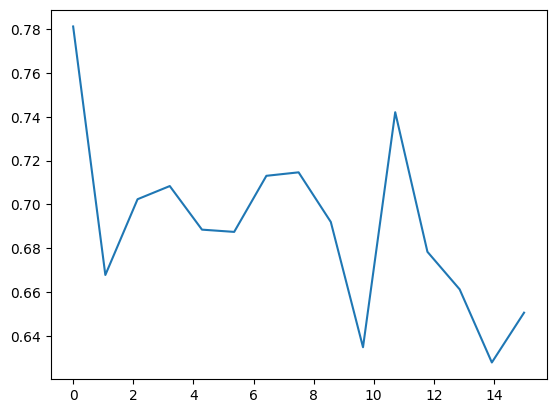

In [119]:
import matplotlib.pyplot as plt
step = np.linspace(0,15,15)
plt.plot(step,np.array(losslist))

In [120]:
losslist

[0.7812263369560242,
 0.667765736579895,
 0.7023563981056213,
 0.708367109298706,
 0.6884681582450867,
 0.6874380707740784,
 0.7130456566810608,
 0.7146310210227966,
 0.6919736266136169,
 0.6347765922546387,
 0.7420870065689087,
 0.6783511638641357,
 0.661220908164978,
 0.6278173327445984,
 0.6505492329597473]